# CV

## 流程

1. 获取数据，将数据转化为tensor
2. 建立模型
    - 选一个loss函数、优化器
    - 选择视觉模型、训练模型
3. 预测模型
4. 评估模型
5. 提升模型
    - 加loop次数、增net层数、增加hint的神经数
    - 使用non-linear层
    - 修改学习率、损失函数、优化器
6. 保存模型

## 1. 准备数据

- 从FashionMNIST中获取训练数据和测试数据
- 使用DataLoader获取训练数据和测试数据中的批次

In [1]:
import torch
from torch import nn
import torchvision
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt

print(f"PyTorch version: {torch.__version__}\ntorchvision version: {torchvision.__version__}")

PyTorch version: 1.13.1
torchvision version: 0.14.1


In [2]:
# 获取训练数据、测试数据

train_data = datasets.FashionMNIST(
    root = "data",
    train = True,
    download = True,
    transform = ToTensor(),
    target_transform = None
)

test_data = datasets.FashionMNIST(
    root = "data",
    train = False,
    download = True,
    transform = ToTensor()
)

# 使用对象的__dict__，来查看实例化对象有哪些属性，以字典的形式呈现，
# 当前重要的就是data和targets属性
# train_data.__dict__, train_data.data, train_data.targets

In [3]:
# 输出train_data的第一行数据
# [color_channels=1, height=28, width=28], 'Channel，Weights, Height'

image, label = train_data[0]
image.shape, type(label)

(torch.Size([1, 28, 28]), int)

In [4]:
# 看看train_data的classes里面有什么类，test_data的classes是一致的 

class_names = train_data.classes

Text(0.5, 1.0, '9')

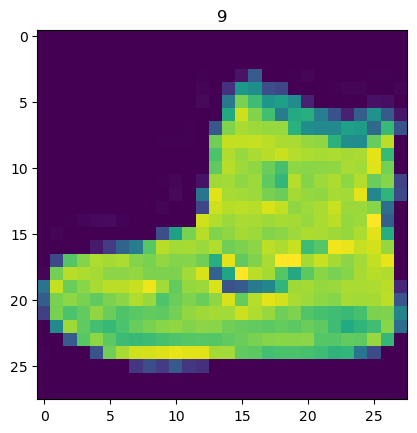

In [5]:
import matplotlib.pyplot as plt
image, label = train_data[0]
plt.imshow(image.squeeze())
plt.title(label)

Text(0.5, 1.0, 'Ankle boot')

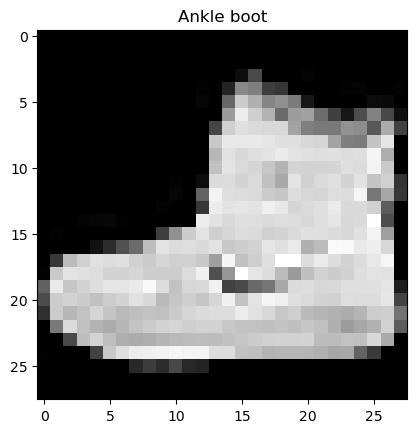

In [6]:
plt.imshow(image.squeeze(), cmap="gray")
plt.title(class_names[label])

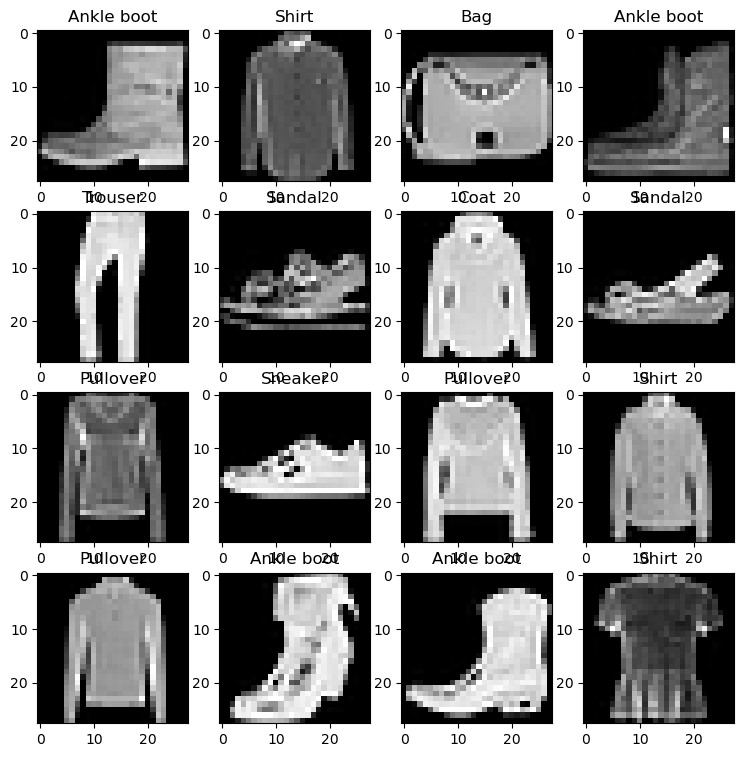

In [7]:
torch.manual_seed(42)
fig = plt.figure(figsize=(9,9))
rows, cols = 4, 4
for i in range(1, rows * cols + 1):
    random_idx = torch.randint(0, len(train_data), size=[1]).item()
    img, label = train_data[random_idx]
    fig.add_subplot(rows, cols, i)
    plt.imshow(img.squeeze(), cmap="gray")
    plt.title(class_names[label])
    plt.axis(True)

In [8]:
from torch.utils.data import DataLoader

BATCH_SIZE = 32
train_dataloader = DataLoader(train_data, 
                              batch_size = BATCH_SIZE,
                              shuffle = True)

test_dataloader = DataLoader(test_data,
                             batch_size=BATCH_SIZE,
                             shuffle=False)

## 看看train_dataloader里面有什么东西，
train_features_batch, train_labels_batch = next(iter(train_dataloader))
test_features_batch, test_labels_batch = next(iter(test_dataloader))
# i = 0
# for x in iter(train_dataloader):
#     i = i+1
# print(i * 32)

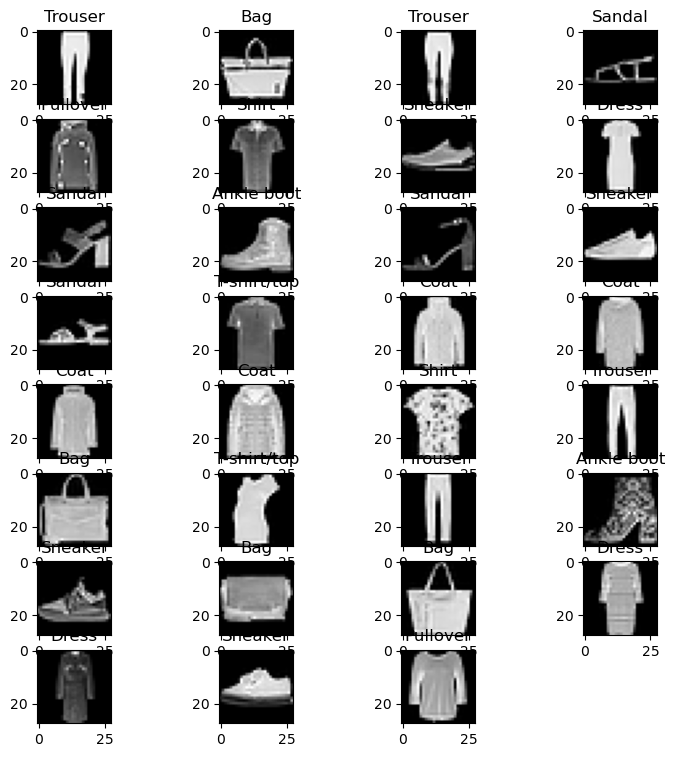

In [9]:
torch.manual_seed(42)
fig = plt.figure(figsize = (9, 9))
for i in range(1, len(train_features_batch)):
    random_idx = torch.randint(0, len(train_features_batch), size=[1]).item()
    img, label = train_features_batch[i], train_labels_batch[i]
    fig.add_subplot(8, 4, i)
    plt.imshow(img.squeeze(), cmap="gray")
    plt.title(class_names[label])

##  2. 建立基线模型

In [10]:
# nn.Flatten() 让 [1, 28, 28] 变成为 [1, 784]，线性层y = x * W.t() + b

flatten_model = nn.Flatten()
x = train_features_batch[0]

output = flatten_model(x)

In [11]:
from torch import nn

class FashionMNISTModelV0(nn.Module):
    def __init__(self, input_shape: int, hidden_shape: int, output_shape: int):
        super().__init__()
        self.layer_stack = nn.Sequential(
            # 简单的网络层级，
            nn.Flatten(), 
            nn.Linear(in_features=input_shape, out_features=hidden_shape),
            nn.Linear(in_features=hidden_shape, out_features=output_shape)
        )
        
    def forward(self, x):
        return self.layer_stack(x)

In [12]:
torch.manual_seed(42)

model_0 = FashionMNISTModelV0(input_shape=784, hidden_shape=10, output_shape=len(class_names))

In [13]:
import requests
from pathlib import Path


if Path("helper_functions.py").is_file():
    print("helper_functions.py is already prepared")
else:
    print("Downloading helper_function.py")
    request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
    with open("helper_functions.py", "wb") as f:
        f.write(request.content)

helper_functions.py is already prepared


In [14]:
from helper_functions import accuracy_fn

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model_0.parameters(), lr=0.1)

In [15]:
from timeit import default_timer as timer 

def print_train_time(start: float, end: float, device: torch.device = None):
    total_time = end - start
    print(f"Train time on {device}: {total_time:.3f} seconds")
    return total_time

### 对模型进行训练

In [16]:
# 对模型进行训练

# 显示进度条
from tqdm.auto import tqdm

torch.manual_seed(42)
train_time_start_on_cpu = timer()
epochs = 3

for epoch in tqdm(range(epochs)):
    print(f"Epoch: {epoch}\n-------")
    
    # 训练
    train_loss = 0
    for batch, (X, y) in enumerate(train_dataloader):
        model_0.train()
        y_pred = model_0(X)
        loss = loss_fn(y_pred, y)
        train_loss += loss
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if batch % 400 == 0:
            print(f"Looked at {batch * len(X)}/{len(train_dataloader.dataset)} samples")
            
    train_loss /= len(train_dataloader)
    
    # 测试
    test_loss, test_acc = 0, 0 
    model_0.eval()
    with torch.inference_mode():
        for X, y in test_dataloader:
            test_pred = model_0(X)
            test_loss += loss_fn(test_pred, y)
            test_acc += accuracy_fn(y_true=y, y_pred=test_pred.argmax(dim=1))
        
        test_loss /= len(test_dataloader)
        test_acc /= len(test_dataloader)
    print(f"\nTrain loss: {train_loss:.5f} | Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%\n")

# 计算时间
train_time_end_on_cpu = timer()
total_train_time_model_0 = print_train_time(start=train_time_start_on_cpu, 
                                           end=train_time_end_on_cpu,
                                           device=str(next(model_0.parameters()).device))

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 0
-------
Looked at 0/60000 samples
Looked at 12800/60000 samples
Looked at 25600/60000 samples
Looked at 38400/60000 samples
Looked at 51200/60000 samples

Train loss: 0.59039 | Test loss: 0.50954, Test acc: 82.04%

Epoch: 1
-------
Looked at 0/60000 samples
Looked at 12800/60000 samples
Looked at 25600/60000 samples
Looked at 38400/60000 samples
Looked at 51200/60000 samples

Train loss: 0.47633 | Test loss: 0.47989, Test acc: 83.20%

Epoch: 2
-------
Looked at 0/60000 samples
Looked at 12800/60000 samples
Looked at 25600/60000 samples
Looked at 38400/60000 samples
Looked at 51200/60000 samples

Train loss: 0.45503 | Test loss: 0.47664, Test acc: 83.43%

Train time on cpu: 22.280 seconds


## 4. 做预测和评估

In [17]:
torch.manual_seed(42)

def eval_model(model: torch.nn.Module, 
               data_loader: torch.utils.data.DataLoader, 
               loss_fn: torch.nn.Module, 
               accuracy_fn):
    
    loss, acc = 0, 0
    model.eval()
    # 使用torch.inference_mode()来进行预测
    with torch.inference_mode():
        for X, y in data_loader:
            # Make predictions with the model
            y_pred = model(X)
            
            # Accumulate the loss and accuracy values per batch
            loss += loss_fn(y_pred, y)
            acc += accuracy_fn(y_true=y, 
                                y_pred=y_pred.argmax(dim=1)) # For accuracy, need the prediction labels (logits -> pred_prob -> pred_labels)
        
        # Scale loss and acc to find the average loss/acc per batch
        loss /= len(data_loader)
        acc /= len(data_loader)
        
    return {"model_name": model.__class__.__name__, # only works when model was created with a class
            "model_loss": loss.item(),
            "model_acc": acc}

# Calculate model 0 results on test dataset
model_0_results = eval_model(model=model_0, data_loader=test_dataloader,
    loss_fn=loss_fn, accuracy_fn=accuracy_fn
)
model_0_results

{'model_name': 'FashionMNISTModelV0',
 'model_loss': 0.4766390025615692,
 'model_acc': 83.42651757188499}

## 5. 优化网络

上面模型的准确率有点低

In [20]:
import torch
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [35]:
# 1.构建一个新的模型

class FashionMNISTModelV1(nn.Module):
    def __init__(self, input_shape: int, hidden_shape: int, output_shape: int):
        super().__init__()
        self.layer_stack = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=input_shape, out_features=hidden_shape),
            nn.ReLU(),
            nn.Linear(in_features=hidden_shape, out_features=output_shape),
            nn.ReLU()
        )
    def forward(self, x:torch.Tensor):
        return self.layer_stack(x)
model_1 = FashionMNISTModelV1(input_shape=784, hidden_shape=10, output_shape=len(class_names))
next(model_1.parameters()).device

device(type='cpu')

In [36]:
# 2.选择损失函数和优化器

# 交叉熵损失函数和随机梯度优化器
loss = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model_1.parameters(), lr=0.01)

进行训练loop和测试loop

1. 训练loop
    - 将input数据丢入网络，通过forward函数，获取output数据
    - 将梯度置零
    - 将监督数据和output数据丢入loss函数
    - 